In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import seaborn as sns
%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

import tensorflow as tf
from numpy.random import seed
tf.random.set_seed(1)
seed(1)

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
test

id        date  store  item
0          0  2018-01-01      1     1
1          1  2018-01-02      1     1
2          2  2018-01-03      1     1
3          3  2018-01-04      1     1
4          4  2018-01-05      1     1
...      ...         ...    ...   ...
44995  44995  2018-03-27     10    50
44996  44996  2018-03-28     10    50
44997  44997  2018-03-29     10    50
44998  44998  2018-03-30     10    50
44999  44999  2018-03-31     10    50

[45000 rows x 4 columns]

In [4]:
train

date  store  item  sales
0       2013-01-01      1     1     13
1       2013-01-02      1     1     11
2       2013-01-03      1     1     14
3       2013-01-04      1     1     13
4       2013-01-05      1     1     10
...            ...    ...   ...    ...
912995  2017-12-27     10    50     63
912996  2017-12-28     10    50     59
912997  2017-12-29     10    50     74
912998  2017-12-30     10    50     62
912999  2017-12-31     10    50     82

[913000 rows x 4 columns]

In [5]:
train

date  store  item  sales
0       2013-01-01      1     1     13
1       2013-01-02      1     1     11
2       2013-01-03      1     1     14
3       2013-01-04      1     1     13
4       2013-01-05      1     1     10
...            ...    ...   ...    ...
912995  2017-12-27     10    50     63
912996  2017-12-28     10    50     59
912997  2017-12-29     10    50     74
912998  2017-12-30     10    50     62
912999  2017-12-31     10    50     82

[913000 rows x 4 columns]

In [6]:
train.shape

(913000, 4)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [8]:
print(train['date'].min())
print(train['date'].max())

2013-01-01
2017-12-31


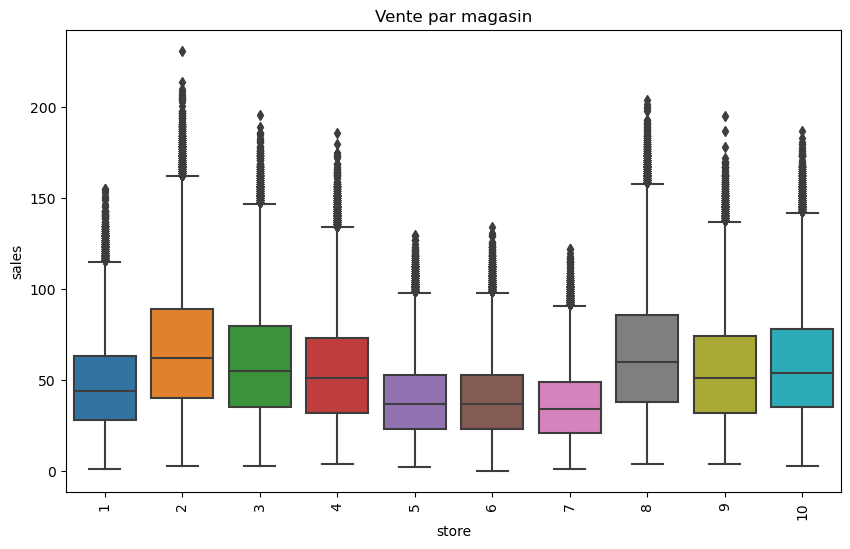

In [9]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="store", y="sales", data=train)
plt.title('Vente par magasin')
plt.xticks(rotation=90)
plt.show()

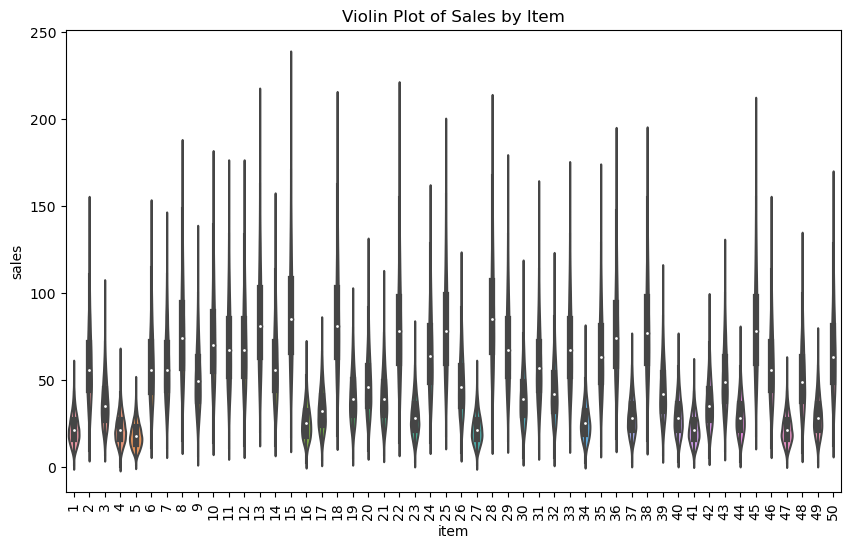

In [10]:
plt.figure(figsize=(10, 6))
sns.violinplot(x="item", y="sales", data=train)
plt.title('Violin Plot of Sales by Item')
plt.xticks(rotation=90)
plt.show()

In [11]:
lag_size = (test['date'].max().date() - train['date'].max().date()).days
print('Max date de train: %s' % train['date'].max().date())
print('Max date de test: %s' % test['date'].max().date())
print('Le délai entre train et test est', lag_size, "jours.")

AttributeError: 'str' object has no attribute 'date'

In [12]:
daily_sales = train.groupby('date', as_index=False)['sales'].sum()
store_daily_sales = train.groupby(['store', 'date'], as_index=False)['sales'].sum()
item_daily_sales = train.groupby(['item', 'date'], as_index=False)['sales'].sum()

In [13]:
daily_sales_sc = go.Scatter(x=daily_sales['date'], y=daily_sales['sales'], line=dict(color='green'))
layout = go.Layout(title='Ventes/Jour', xaxis=dict(title='Date'), yaxis=dict(title='Ventes'))
fig = go.Figure(data=[daily_sales_sc], layout=layout)
iplot(fig)

In [14]:
item_daily_sales_sc = []
for item in item_daily_sales['item'].unique():
    current_item_daily_sales = item_daily_sales[(item_daily_sales['item'] == item)]
    item_daily_sales_sc.append(go.Scatter(x=current_item_daily_sales['date'], y=current_item_daily_sales['sales'], name=('Item %s' % item)))

layout = go.Layout(title='Item daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=item_daily_sales_sc, layout=layout)
iplot(fig)

In [ ]:
store_daily_sales_sc = []
for store in store_daily_sales['store'].unique():
    current_store_daily_sales = store_daily_sales[(store_daily_sales['store'] == store)]
    store_daily_sales_sc.append(go.Scatter(x=current_store_daily_sales['date'], y=current_store_daily_sales['sales'], name=('Store %s' % store)))

layout = go.Layout(title='Ventes par magasin', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=store_daily_sales_sc, layout=layout)
iplot(fig)

# Data Preprocessing

In [37]:
train.shape

(913000, 4)

In [ ]:
train.head(10)

In [38]:
train=train[(train["date"]>='2016-01-01')]

In [39]:
train_gp = train.sort_values('date').groupby(['item', 'store', 'date'], as_index=False)
train_gp = train_gp.agg({'sales':['mean']})
train_gp.columns = ['item', 'store', 'date', 'sales']
train_gp.head()

item  store       date  sales
0     1      1 2016-01-01   21.0
1     1      1 2016-01-02   13.0
2     1      1 2016-01-03   12.0
3     1      1 2016-01-04   12.0
4     1      1 2016-01-05   12.0

In [40]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [41]:
window = 29
lag = lag_size
series = series_to_supervised(train_gp.drop('date', axis=1), window=window, lag=lag)
series

item(t-29)  store(t-29)  sales(t-29)  item(t-28)  store(t-28)  \
29             1.0          1.0         21.0         1.0          1.0   
30             1.0          1.0         13.0         1.0          1.0   
31             1.0          1.0         12.0         1.0          1.0   
32             1.0          1.0         12.0         1.0          1.0   
33             1.0          1.0         12.0         1.0          1.0   
...            ...          ...          ...         ...          ...   
365405        50.0         10.0         79.0        50.0         10.0   
365406        50.0         10.0         89.0        50.0         10.0   
365407        50.0         10.0         96.0        50.0         10.0   
365408        50.0         10.0         92.0        50.0         10.0   
365409        50.0         10.0        102.0        50.0         10.0   

        sales(t-28)  item(t-27)  store(t-27)  sales(t-27)  item(t-26)  ...  \
29             13.0         1.0          1.0         12.0         1.0  ...   
30             12.0         1.0          1.0         12.0         1.0  ...   
31             12.0         1.0          1.0         12.0         1.0  ...   
32             12.0         1.0          1.0         16.0         1.0  ...   
33             16.0         1.0          1.0         12.0         1.0  ...   
...             ...         ...          ...          ...         ...  ...   
365405         89.0        50.0         10.0         96.0        50.0  ...   
365406         96.0        50.0         10.0         92.0        50.0  ...   
365407         92.0        50.0         10.0        102.0        50.0  ...   
365408        102.0        50.0         10.0         60.0        50.0  ...   
365409         60.0        50.0         10.0         81.0        50.0  ...   

        sales(t-2)  item(t-1)  store(t-1)  sales(t-1)  item(t)  store(t)  \
29            17.0        1.0         1.0        16.0        1         1   
30            16.0        1.0         1.0        14.0        1         1   
31            14.0        1.0         1.0        14.0        1         1   
32            14.0        1.0         1.0        16.0        1         1   
33            16.0        1.0         1.0        16.0        1         1   
...            ...        ...         ...         ...      ...       ...   
365405        79.0       50.0        10.0        80.0       50        10   
365406        80.0       50.0        10.0        82.0       50        10   
365407        82.0       50.0        10.0        90.0       50        10   
365408        90.0       50.0        10.0       103.0       50        10   
365409       103.0       50.0        10.0        99.0       50        10   

        sales(t)  item(t+90)  store(t+90)  sales(t+90)  
29          14.0         1.0          1.0         30.0  
30          14.0         1.0          1.0         30.0  
31          16.0         1.0          1.0         30.0  
32          16.0         1.0          1.0         18.0  
33          19.0         1.0          1.0         29.0  
...          ...         ...          ...          ...  
365405      82.0        50.0         10.0         63.0  
365406      90.0        50.0         10.0         59.0  
365407     103.0        50.0         10.0         74.0  
365408      99.0        50.0         10.0         62.0  
365409      71.0        50.0         10.0         82.0  

[365381 rows x 93 columns]

In [43]:
final_item = 'item(t-%d)' % window
final_store = 'store(t-%d)' % window
filtered_series = series[(series['store(t)'] == series[final_store])]
filtered_series = filtered_series[(filtered_series['item(t)'] == filtered_series[final_item])]
drop_columns = [('%s(t+%d)' % (col, lag)) for col in ['item', 'store']]
for i in range(window, 0, -1):
    drop_columns += [('%s(t-%d)' % (col, i)) for col in ['item', 'store']]
filtered_series.drop(drop_columns, axis=1, inplace=True)
filtered_series.drop(['item(t)', 'store(t)'], axis=1, inplace=True)
label_column = 'sales(t+%d)' % lag_size
extracted_labels = filtered_series[label_column]
filtered_series = filtered_series.drop(label_column, axis=1)

X_train_set, X_valid_set, Y_train_set, Y_valid_set = train_test_split(filtered_series, extracted_labels.values, test_size=0.4, random_state=0)
print('Train set dimensions', X_train_set.shape)
print('Validation set dimensions', X_valid_set.shape)
X_train_set

Train set shape (210546, 30)
Validation set shape (140364, 30)


sales(t-29)  sales(t-28)  sales(t-27)  sales(t-26)  sales(t-25)  \
291755         26.0         39.0         21.0         31.0         28.0   
137905         36.0         51.0         42.0         40.0         49.0   
230774         44.0         38.0         51.0         40.0         39.0   
176761        162.0        193.0        123.0        127.0        125.0   
204067         77.0         91.0        120.0        114.0        144.0   
...             ...          ...          ...          ...          ...   
127654         54.0         76.0         79.0         65.0         77.0   
316723         24.0         33.0         30.0         33.0         43.0   
158608         53.0         48.0         66.0         59.0         88.0   
122853         41.0         23.0         21.0         15.0         27.0   
318355         18.0         14.0         22.0         17.0         20.0   

        sales(t-24)  sales(t-23)  sales(t-22)  sales(t-21)  sales(t-20)  ...  \
291755         34.0         33.0         42.0         32.0         24.0  ...   
137905         47.0         42.0         47.0         49.0         55.0  ...   
230774         35.0         34.0         38.0         34.0         43.0  ...   
176761        133.0        171.0        181.0        170.0        124.0  ...   
204067         95.0         93.0         84.0        106.0        124.0  ...   
...             ...          ...          ...          ...          ...  ...   
127654         66.0         55.0         71.0         58.0         60.0  ...   
316723         40.0         52.0         39.0         32.0         42.0  ...   
158608         78.0         46.0         53.0         72.0         68.0  ...   
122853         30.0         19.0         28.0         16.0         21.0  ...   
318355         13.0         17.0         23.0         16.0         25.0  ...   

        sales(t-9)  sales(t-8)  sales(t-7)  sales(t-6)  sales(t-5)  \
291755        42.0        36.0        33.0        31.0        34.0   
137905        56.0        44.0        47.0        62.0        41.0   
230774        40.0        42.0        39.0        47.0        53.0   
176761       138.0       140.0       158.0        88.0       123.0   
204067        93.0        96.0       106.0       104.0       138.0   
...            ...         ...         ...         ...         ...   
127654        48.0        59.0        58.0        65.0        59.0   
316723        43.0        26.0        28.0        34.0        47.0   
158608        51.0        36.0        46.0        42.0        43.0   
122853        44.0        33.0        23.0        24.0        21.0   
318355        18.0        17.0         7.0        20.0        14.0   

        sales(t-4)  sales(t-3)  sales(t-2)  sales(t-1)  sales(t)  
291755        29.0        27.0        26.0        27.0      37.0  
137905        48.0        42.0        43.0        48.0      62.0  
230774        41.0        43.0        28.0        36.0      51.0  
176761       117.0       134.0       136.0       154.0     146.0  
204067       140.0        99.0       100.0       119.0     103.0  
...            ...         ...         ...         ...       ...  
127654        77.0        99.0        62.0        79.0      70.0  
316723        36.0        51.0        54.0        40.0      38.0  
158608        39.0        70.0        32.0        44.0      45.0  
122853        30.0        29.0        29.0        30.0      20.0  
318355        18.0        13.0         8.0        10.0      19.0  

[210546 rows x 30 columns]

# MLP

In [22]:
epochs = 32
batch = 256
lr = 0.0003
adam = optimizers.Adam(lr)

In [23]:
model_mlp = Sequential()
model_mlp.add(Dense(5,1, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mse', optimizer=adam)
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1984      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,049
Trainable params: 2,049
Non-trainable params: 0
_________________________________________________________________


In [55]:
model_mlp1 = Sequential()
model_mlp1.add(Dense(5, activation='tanh', input_dim=X_train.shape[1]))
model_mlp1.add(Dense(1))

model_mlp1.compile(loss='mse', optimizer=adam)
model_mlp1.summary()
mlp_history1=model_mlp1.fit(X_train.values, Y_train, validation_data=(X_valid.values, Y_valid), epochs=epochs, verbose=2)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 5)                 155       
                                                                 
 dense_14 (Dense)            (None, 1)                 6         
                                                                 
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
3149/3149 - 5s - loss: 2928.6426 - val_loss: 2141.7576 - 5s/epoch - 1ms/step
Epoch 2/32
3149/3149 - 4s - loss: 1700.7800 - val_loss: 1330.8718 - 4s/epoch - 1ms/step
Epoch 3/32
3149/3149 - 4s - loss: 1154.9358 - val_loss: 1028.9850 - 4s/epoch - 1ms/step
Epoch 4/32
3149/3149 - 5s - loss: 1008.1325 - val_loss: 985.1576 - 5s/epoch - 2ms/step
Epoch 5/32
3149/3149 - 5s - loss: 993.0705 - val_loss: 985.7544 - 5s/epoch - 2ms/step
Epoch 6/32
3149

In [24]:
mlp_history = model_mlp.fit(X_train.values, Y_train, validation_data=(X_valid.values, Y_valid), epochs=epochs, verbose=2)

Epoch 1/32
3149/3149 - 5s - loss: 412.3674 - val_loss: 384.8250 - 5s/epoch - 2ms/step
Epoch 2/32
3149/3149 - 4s - loss: 376.4430 - val_loss: 369.3114 - 4s/epoch - 1ms/step
Epoch 3/32
3149/3149 - 4s - loss: 364.1208 - val_loss: 372.1598 - 4s/epoch - 1ms/step
Epoch 4/32
3149/3149 - 5s - loss: 360.2366 - val_loss: 386.5714 - 5s/epoch - 1ms/step
Epoch 5/32
3149/3149 - 5s - loss: 358.0571 - val_loss: 361.4992 - 5s/epoch - 1ms/step
Epoch 6/32
3149/3149 - 4s - loss: 356.6351 - val_loss: 356.4950 - 4s/epoch - 1ms/step
Epoch 7/32
3149/3149 - 4s - loss: 354.8748 - val_loss: 359.9561 - 4s/epoch - 1ms/step
Epoch 8/32
3149/3149 - 4s - loss: 353.9096 - val_loss: 353.0240 - 4s/epoch - 1ms/step
Epoch 9/32
3149/3149 - 5s - loss: 353.2383 - val_loss: 353.3571 - 5s/epoch - 1ms/step
Epoch 10/32
3149/3149 - 4s - loss: 352.2875 - val_loss: 351.5921 - 4s/epoch - 1ms/step
Epoch 11/32
3149/3149 - 5s - loss: 351.5741 - val_loss: 351.4061 - 5s/epoch - 1ms/step
Epoch 12/32
3149/3149 - 5s - loss: 350.3792 - val_lo

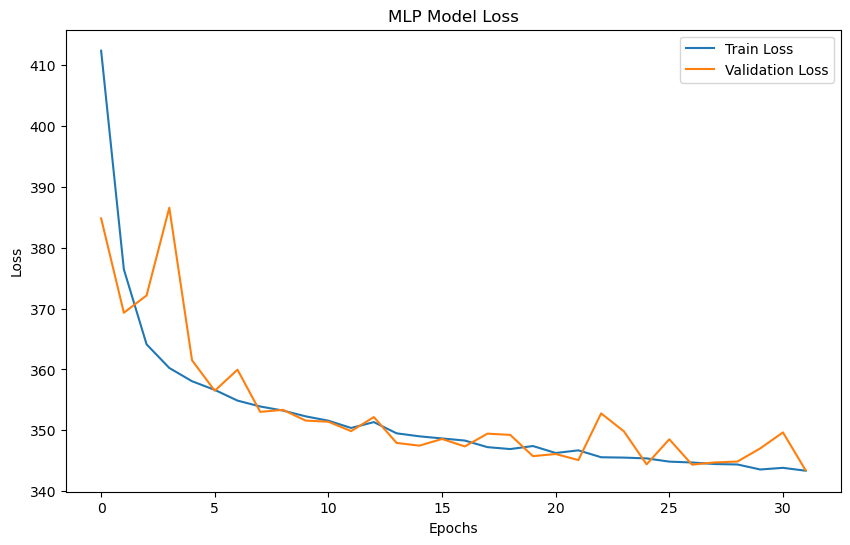

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(mlp_history.history['loss'], label='Train Loss')
plt.plot(mlp_history.history['val_loss'], label='Validation Loss')
plt.title('MLP Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

2099/2099 [==============================] - 2s 884us/step


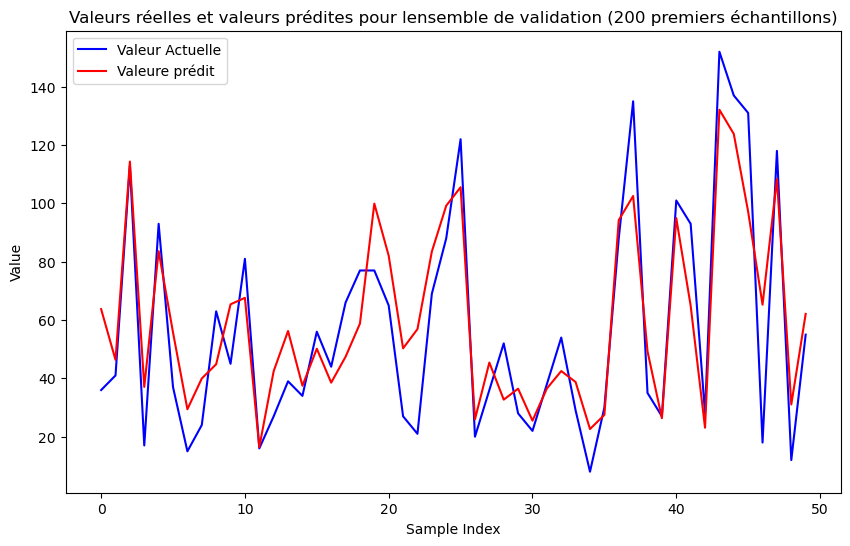

In [27]:
import matplotlib.pyplot as plt
Y_valid_pred = model_mlp.predict(X_valid.values)
Y_valid_actual = Y_valid[:50]
Y_valid_pred = Y_valid_pred[:50]
plt.figure(figsize=(10, 6))
plt.plot(Y_valid_actual, 'b-', label='Valeur Actuelle')
plt.plot(Y_valid_pred, 'r-', label='Valeure prédit')
plt.legend()
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Valeurs réelles et valeurs prédites pour lensemble de validation (200 premiers échantillons)')
plt.show()

# CNN for Time Series Forecasting : 


# Date preprocess: 

In [ ]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))

In [29]:
X_train_series

array([[[ 97.],
        [111.],
        [ 90.],
        ...,
        [101.],
        [102.],
        [114.]],

       [[ 38.],
        [ 43.],
        [ 43.],
        ...,
        [ 24.],
        [ 30.],
        [ 37.]],

       [[ 55.],
        [ 45.],
        [ 41.],
        ...,
        [ 38.],
        [ 50.],
        [ 49.]],

       ...,

       [[ 86.],
        [ 78.],
        [ 76.],
        ...,
        [ 70.],
        [ 53.],
        [ 57.]],

       [[ 80.],
        [ 70.],
        [ 81.],
        ...,
        [ 62.],
        [ 78.],
        [ 80.]],

       [[135.],
        [140.],
        [ 98.],
        ...,
        [113.],
        [107.],
        [139.]]])

In [30]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(40, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=adam)
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 29, 64)            192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 14, 64)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 896)               0         
                                                                 
 dense_2 (Dense)             (None, 40)                35880     
                                                                 
 dense_3 (Dense)             (None, 1)                 41        
                                                                 
Total params: 36,113
Trainable params: 36,113
Non-trainable params: 0
__________________________________________________

In [31]:
cnn_history = model_cnn.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/32
3149/3149 - 8s - loss: 413.2352 - val_loss: 385.0841 - 8s/epoch - 3ms/step
Epoch 2/32
3149/3149 - 8s - loss: 382.0254 - val_loss: 379.9861 - 8s/epoch - 2ms/step
Epoch 3/32
3149/3149 - 8s - loss: 371.7643 - val_loss: 372.4159 - 8s/epoch - 2ms/step
Epoch 4/32
3149/3149 - 8s - loss: 367.7239 - val_loss: 381.6154 - 8s/epoch - 3ms/step
Epoch 5/32
3149/3149 - 8s - loss: 365.8566 - val_loss: 365.7209 - 8s/epoch - 2ms/step
Epoch 6/32
3149/3149 - 8s - loss: 363.8070 - val_loss: 359.7061 - 8s/epoch - 2ms/step
Epoch 7/32
3149/3149 - 8s - loss: 361.8023 - val_loss: 365.3510 - 8s/epoch - 2ms/step
Epoch 8/32
3149/3149 - 8s - loss: 360.3352 - val_loss: 356.0775 - 8s/epoch - 2ms/step
Epoch 9/32
3149/3149 - 8s - loss: 359.0826 - val_loss: 358.4303 - 8s/epoch - 3ms/step
Epoch 10/32
3149/3149 - 8s - loss: 357.3143 - val_loss: 353.7582 - 8s/epoch - 3ms/step
Epoch 11/32
3149/3149 - 8s - loss: 355.8188 - val_loss: 351.9341 - 8s/epoch - 3ms/step
Epoch 12/32
3149/3149 - 8s - loss: 354.3851 - val_lo

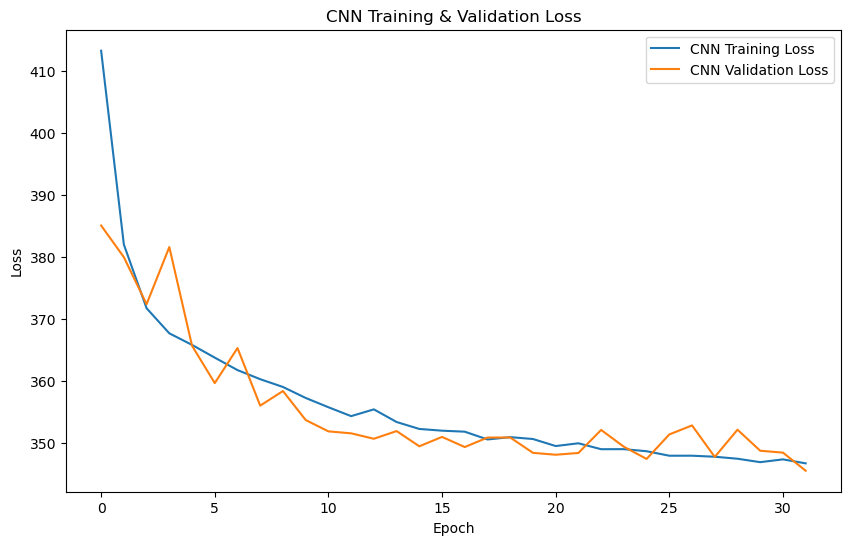

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(cnn_history.history['loss'], label='CNN Training Loss')
plt.plot(cnn_history.history['val_loss'], label='CNN Validation Loss')
plt.title('CNN Training & Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

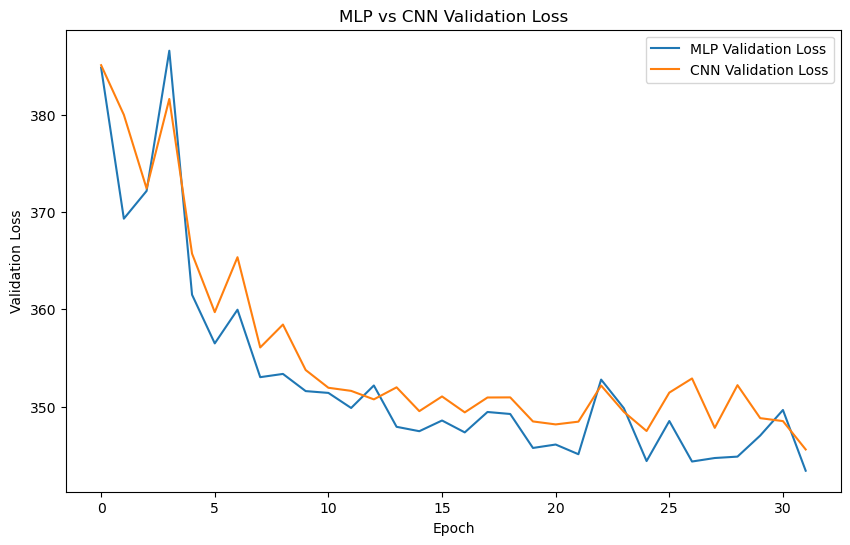

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(mlp_history.history['val_loss'], label='MLP Validation Loss')
plt.plot(cnn_history.history['val_loss'], label='CNN Validation Loss')
plt.title('MLP vs CNN Validation Loss')
plt.ylabel('Validation Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

2099/2099 [==============================] - 2s 1ms/step


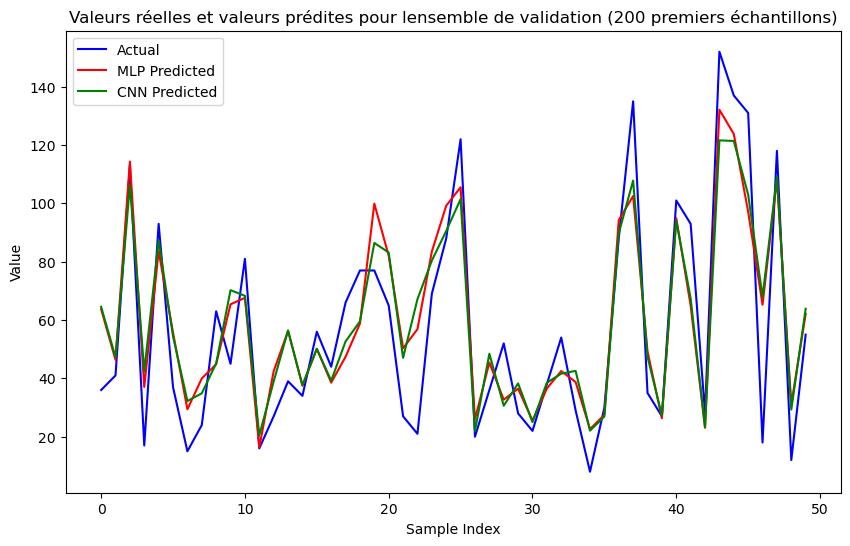

In [34]:
import matplotlib.pyplot as plt

Y_valid_pred_mlp = model_mlp.predict(X_valid.values)
Y_valid_pred_cnn = model_cnn.predict(X_valid_series)
Y_valid_actual = Y_valid[:50]
Y_valid_pred_mlp = Y_valid_pred_mlp[:50]
Y_valid_pred_cnn = Y_valid_pred_cnn[:50]
plt.figure(figsize=(10, 6))
plt.plot(Y_valid_actual, 'b-', label='Actual')
plt.plot(Y_valid_pred_mlp, 'r-', label='MLP Predicted')
plt.plot(Y_valid_pred_cnn, 'g-', label='CNN Predicted')
plt.legend()
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Valeurs réelles et valeurs prédites pour lensemble de validation (200 premiers échantillons)')
plt.show()


# CNN-LSTM¶


In [35]:
from keras.optimizers import Adam
subsequences = 2
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), 
                                    input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(100, activation='tanh', return_sequences=True))  
model_cnn_lstm.add(LSTM(50, activation='tanh'))  
model_cnn_lstm.add(Dense(1))
adam = Adam(learning_rate=0.001)
model_cnn_lstm.compile(loss='mse', optimizer=adam)
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), 
                                      epochs=50, verbose=2)

Train set shape (100746, 2, 15, 1)
Validation set shape (67164, 2, 15, 1)
Epoch 1/50
3149/3149 - 31s - loss: 1083.9635 - val_loss: 490.8517 - 31s/epoch - 10ms/step
Epoch 2/50
3149/3149 - 26s - loss: 430.2303 - val_loss: 405.4821 - 26s/epoch - 8ms/step
Epoch 3/50
3149/3149 - 27s - loss: 398.2721 - val_loss: 390.2991 - 27s/epoch - 8ms/step
Epoch 4/50
3149/3149 - 27s - loss: 388.4790 - val_loss: 393.5387 - 27s/epoch - 8ms/step
Epoch 5/50
3149/3149 - 27s - loss: 384.3178 - val_loss: 373.7946 - 27s/epoch - 9ms/step
Epoch 6/50
3149/3149 - 27s - loss: 378.4186 - val_loss: 375.1351 - 27s/epoch - 9ms/step
Epoch 7/50
3149/3149 - 27s - loss: 374.4552 - val_loss: 377.8490 - 27s/epoch - 9ms/step
Epoch 8/50
3149/3149 - 27s - loss: 370.6259 - val_loss: 363.4865 - 27s/epoch - 9ms/step
Epoch 9/50
3149/3149 - 27s - loss: 369.0443 - val_loss: 370.7078 - 27s/epoch - 9ms/step
Epoch 10/50
3149/3149 - 27s - loss: 367.6849 - val_loss: 364.3687 - 27s/epoch - 9ms/step
Epoch 11/50
3149/3149 - 27s - loss: 366.376

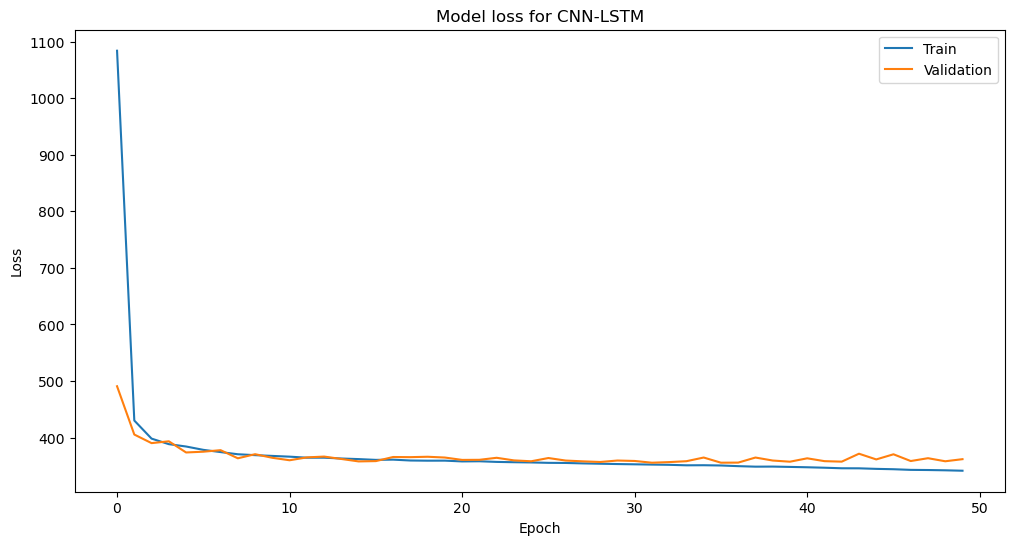

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(cnn_lstm_history.history['loss'])
plt.plot(cnn_lstm_history.history['val_loss'])
plt.title('Model loss for CNN-LSTM')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

2099/2099 [==============================] - 7s 3ms/step


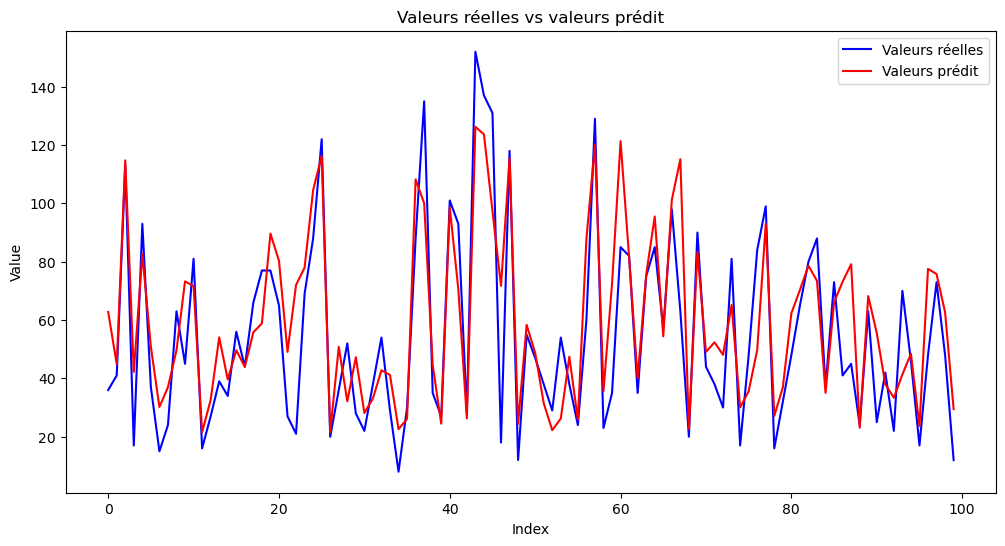

In [37]:
predictions = model_cnn_lstm.predict(X_valid_series_sub)
plt.figure(figsize=(12,6))
plt.plot(Y_valid[:100], color='blue', label='Valeurs réelles')
plt.plot(predictions[:100], color='red', label='Valeurs prédit')
plt.title('Valeurs réelles vs valeurs prédit')
plt.ylabel('Value')
plt.xlabel('Index')
plt.legend(loc='upper right')
plt.show()

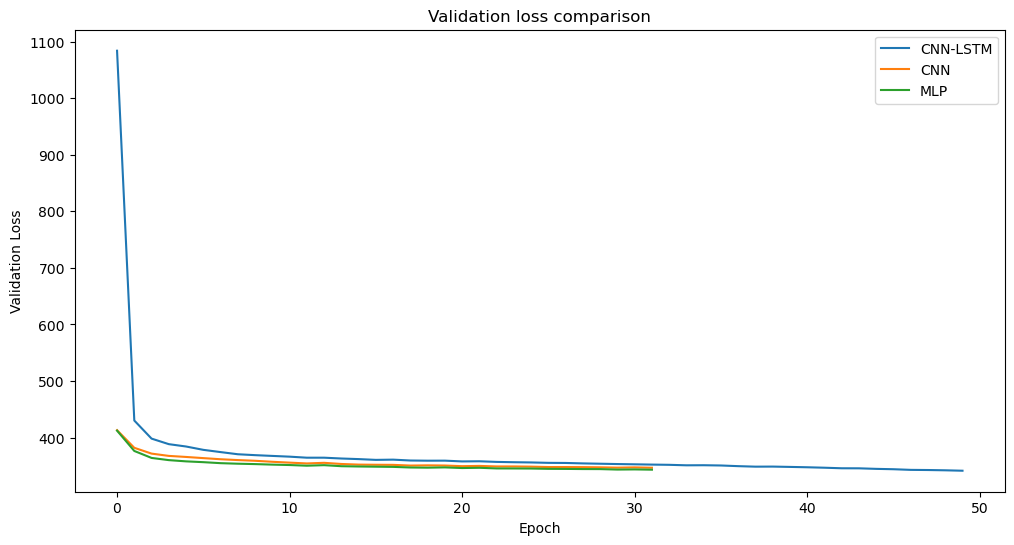

In [40]:
plt.figure(figsize=(12,6))
plt.plot(cnn_lstm_history.history['loss'], label='CNN-LSTM')
plt.plot(cnn_history.history['loss'], label='CNN')
plt.plot(mlp_history.history['loss'], label='MLP')
plt.title('Validation loss comparison')
plt.ylabel('Validation Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

2099/2099 [==============================] - 2s 1ms/step


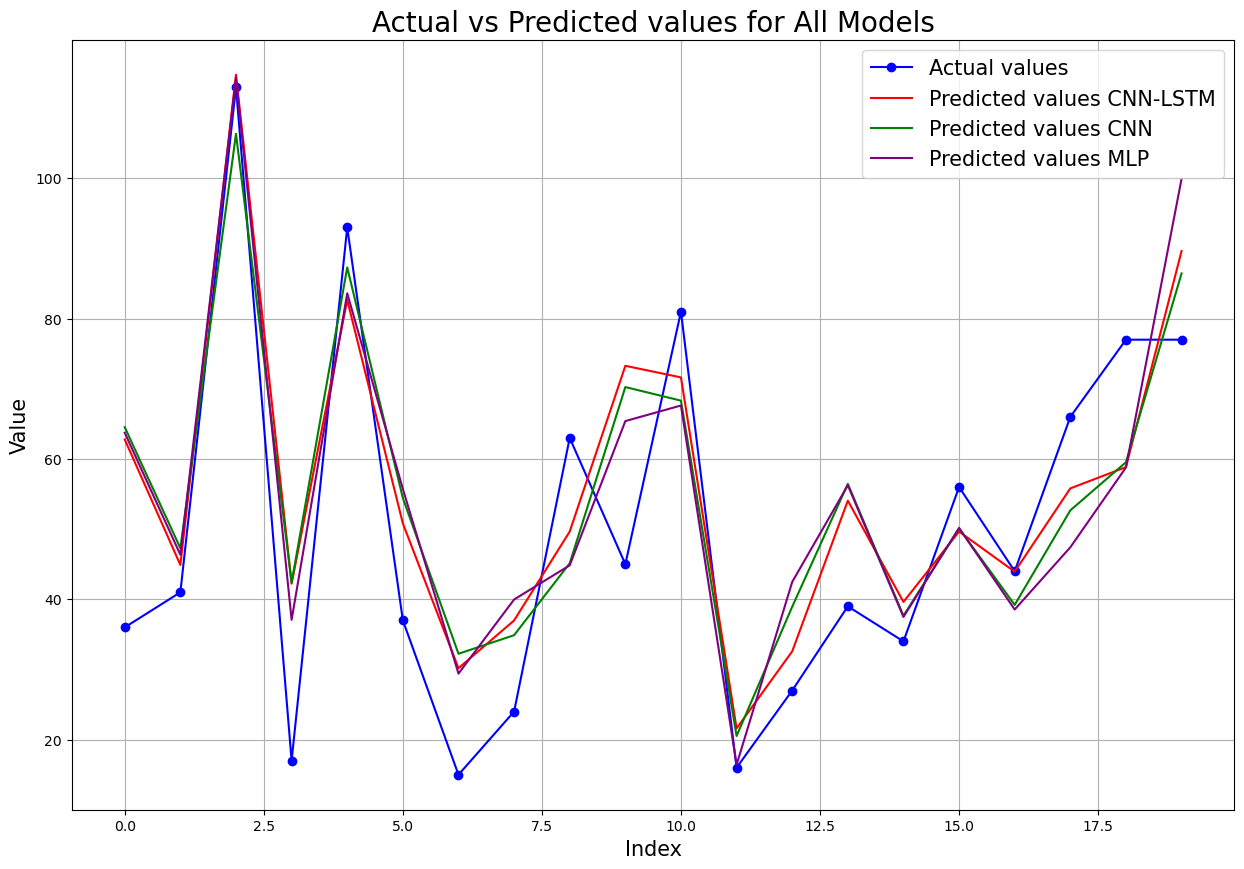

In [45]:
predictions_cnn_lstm = model_cnn_lstm.predict(X_valid_series_sub)
predictions_cnn = model_cnn.predict(X_valid_series)
predictions_mlp = model_mlp.predict(X_valid)
plt.figure(figsize=(15,10))
plt.plot(Y_valid[:20], color='blue', marker='o', label='Actual values')
plt.plot(predictions_cnn_lstm[:20], color='red' , label='Predicted values CNN-LSTM')
plt.plot(predictions_cnn[:20], color='green', label='Predicted values CNN')
plt.plot(predictions_mlp[:20], color='purple', label='Predicted values MLP')
plt.title('Actual vs Predicted values for All Models', fontsize=20)
plt.ylabel('Value', fontsize=15)
plt.xlabel('Index', fontsize=15)
plt.legend(loc='upper right', fontsize=15)
plt.grid(True)

plt.show()

2099/2099 [==============================] - 2s 853us/step


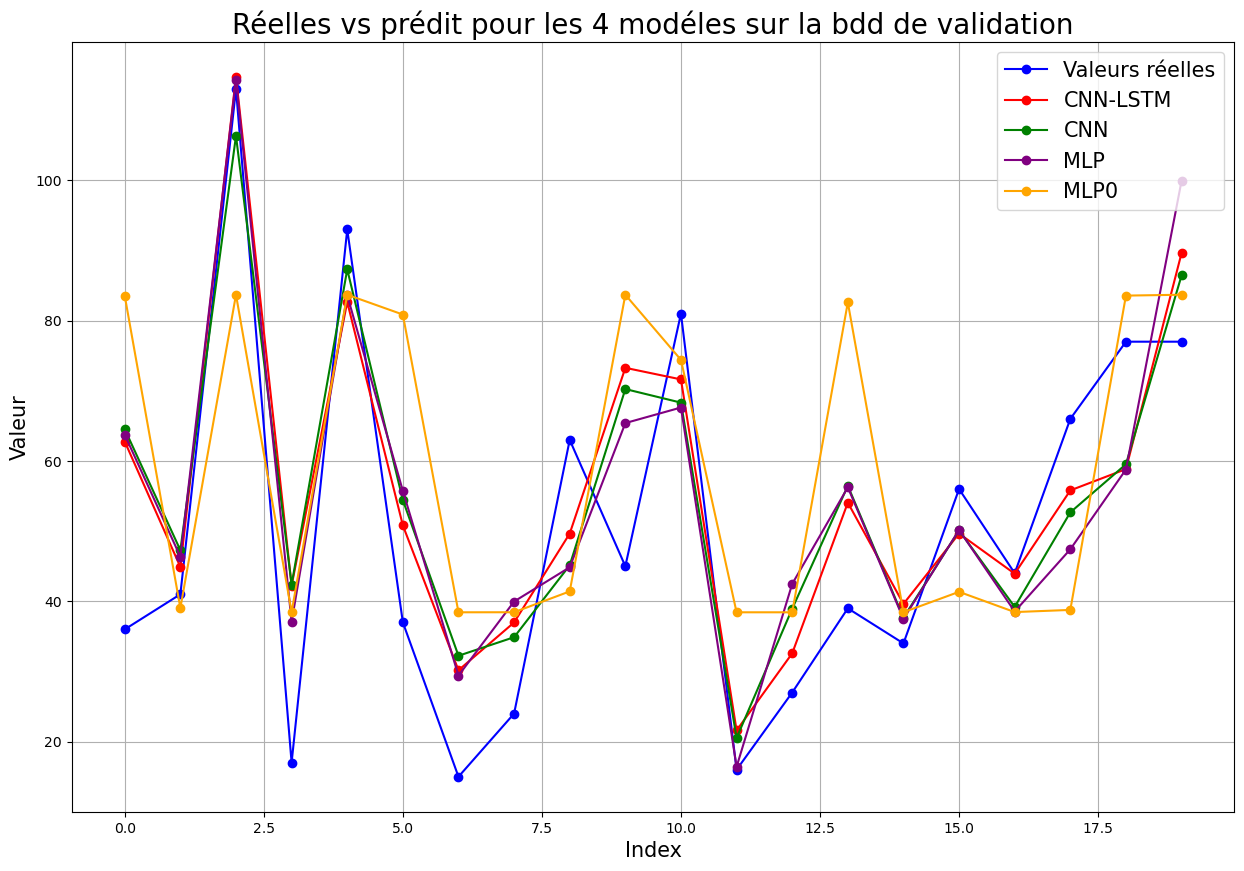

In [57]:
predictions_cnn_lstm = model_cnn_lstm.predict(X_valid_series_sub)
predictions_cnn = model_cnn.predict(X_valid_series)
predictions_mlp = model_mlp.predict(X_valid)
predictions_mlp1 = model_mlp1.predict(X_valid)  
plt.figure(figsize=(15,10))
plt.plot(Y_valid[:20], color='blue', marker='o', label='Valeurs réelles')
plt.plot(predictions_cnn_lstm[:20], color='red', marker='o', label='CNN-LSTM')
plt.plot(predictions_cnn[:20], color='green', marker='o', label='CNN')
plt.plot(predictions_mlp[:20], color='purple', marker='o', label='MLP')
plt.plot(predictions_mlp1[:20], color='orange', marker='o', label='MLP0') 
plt.title('Réelles vs prédit pour les 4 modéles sur la bdd de validation', fontsize=20)
plt.ylabel('Valeur', fontsize=15)
plt.xlabel('Index', fontsize=15)
plt.legend(loc='upper right', fontsize=15)
plt.grid(True)

plt.show()